In [2]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from tqdm import tqdm
from scipy import signal
import json

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [3]:
filtered_df = pd.read_parquet("complete_stock_data.parquet")

In [ ]:
filtered_df.shape

In [ ]:
filtered_df.columns

In [ ]:
#distribution of actual number of trading days per year in the dataset
pd.Series(pd.to_datetime(filtered_df["date"].unique())).dt.year.value_counts().describe()

In [6]:
trading_days_estimate = pd.Series(pd.to_datetime(filtered_df["date"].unique())).dt.year.value_counts().agg(["mean","std"])

In [ ]:
print(254**0.5)
print(248**0.5)
print(trading_days_estimate.loc["mean"]**0.5)

In [ ]:
print((254**0.5-trading_days_estimate.loc["mean"]**0.5)/trading_days_estimate.loc["mean"]**0.5)
print((-248**0.5+trading_days_estimate.loc["mean"]**0.5)/trading_days_estimate.loc["mean"]**0.5)

In [ ]:
def calculate_financial_metrics(df):
    # Sort data
    print("Sorting data...")
    df = df.sort_values(['symbol', 'date'])
    
    # Calculate daily returns
    print("Calculating daily returns...")
    df['daily_return'] = df.groupby('symbol')['close'].pct_change()
    
    # Calculate various metrics by symbol
    metrics = []
    symbols = df['symbol'].unique()
    
    print("Processing symbols...")
    for symbol in tqdm(symbols, desc="Calculating metrics"):
        symbol_data = df[df['symbol'] == symbol]
        
        # Basic metrics
        volatility = symbol_data['daily_return'].std() * (252 ** 0.5)  # Annualized volatility
        avg_volume = symbol_data['volume'].mean()
        
        # Calculate moving averages
        symbol_data['MA50'] = symbol_data['close'].rolling(window=50).mean()
        symbol_data['MA200'] = symbol_data['close'].rolling(window=200).mean()
        
        # Calculate RSI
        delta = symbol_data['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        
        metrics.append({
            'symbol': symbol,
            'volatility': volatility,
            'avg_daily_volume': avg_volume,
            'avg_daily_return': symbol_data['daily_return'].mean(),
            'sharpe_ratio': symbol_data['daily_return'].mean() / symbol_data['daily_return'].std() * (252 ** 0.5),
            'last_rsi': rsi.iloc[-1] if len(rsi) > 0 else None,
            'current_price': symbol_data['close'].iloc[-1],
            'price_change_ytd': (symbol_data['close'].iloc[-1] / symbol_data['close'].iloc[0] - 1) * 100
        })
        
        # Free up memory
        del symbol_data
    
    return pd.DataFrame(metrics)

In [ ]:
financial_analysis = calculate_financial_metrics(filtered_df)

In [ ]:
financial_analysis.shape

In [6]:
financial_analysis.to_parquet("financial_metrics.parquet")

In [ ]:
financial_analysis.sort_values(by=["avg_daily_return","volatility"],ascending=[False])

In [8]:
financial_analysis.to_csv("financial_metrics.csv",index=False)

In [3]:
def analyze_frequency_components(returns, fs=1):
    """
    Analyze the frequency components of a return series using Welch's method
    
    Parameters:
    returns: array-like, return series
    fs: sampling frequency (1 for daily data)
    
    Returns:
    frequencies: array of frequencies
    psd: power spectral density
    """
    # Remove NaN values
    returns = returns.dropna()
    
    # Use Welch's method to estimate power spectral density
    # Using overlapping windows to reduce noise
    frequencies, psd = signal.welch(
        returns,
        fs=fs,
        nperseg=min(256, len(returns)//4),  # Length of each segment
        noverlap=min(128, len(returns)//8),  # Overlap between segments
        detrend='constant',
        scaling='density'
    )
    
    return frequencies, psd

def identify_dominant_cycles(frequencies, psd, min_period=2):
    """
    Identify dominant cycles in the power spectrum
    
    Parameters:
    frequencies: array of frequencies
    psd: power spectral density
    min_period: minimum period to consider (in days)
    
    Returns:
    list of (period, power) tuples sorted by power
    """
    # Convert frequencies to periods
    periods = 1/frequencies
    
    # Find local maxima in the PSD
    peaks = signal.find_peaks(psd)[0]
    
    # Create list of (period, power) tuples for periods > min_period
    cycles = [(periods[i], psd[i]) for i in peaks if periods[i] > min_period]
    
    # Sort by power (descending)
    return sorted(cycles, key=lambda x: x[1], reverse=True)

def analyze_stock_timescales(df, symbol):
    """
    Analyze natural timescales present in a stock's returns
    
    Parameters:
    df: DataFrame with 'symbol', 'date', 'close' columns
    symbol: stock symbol to analyze
    
    Returns:
    dict with analysis results
    """
    # Get symbol data
    symbol_data = df[df['symbol'] == symbol].sort_values('date')
    
    # Calculate returns
    returns = symbol_data['close'].pct_change().dropna()
    
    # Get frequency components
    frequencies, psd = analyze_frequency_components(returns)
    
    # Identify dominant cycles
    cycles = identify_dominant_cycles(frequencies, psd)
    
    # Calculate total power and relative importance of each cycle
    total_power = np.sum(psd)
    
    # Get top cycles and their relative power
    top_cycles = []
    for period, power in cycles[:5]:  # Top 5 cycles
        relative_power = (power / total_power) * 100
        days = period
        if days >= 252:  # Convert to years if >= 1 year
            top_cycles.append({
                'period': f'{days/252:.1f} years',
                'relative_power': relative_power
            })
        elif days >= 21:  # Convert to months if >= 1 month
            top_cycles.append({
                'period': f'{days/21:.1f} months',
                'relative_power': relative_power
            })
        else:
            top_cycles.append({
                'period': f'{days:.1f} days',
                'relative_power': relative_power
            })
    
    return {
        'symbol': symbol,
        'frequencies': frequencies,
        'psd': psd,
        'top_cycles': top_cycles,
        'returns': returns
    }

def plot_spectral_analysis(analysis_result, title=None, window_sizes=[5, 20]):
    """
    Plot the spectral analysis results with dark theme, including smoothed versions
    
    Parameters:
    analysis_result: dict containing frequencies and psd
    title: optional title for the plot
    window_sizes: list of window sizes for different levels of smoothing
    """
    frequencies = analysis_result['frequencies']
    psd = analysis_result['psd'][1:]
    
    # Convert frequencies to periods
    periods = 1/frequencies[1:]
    
    # Set dark theme
    plt.style.use('dark_background')
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot raw PSD vs Period
    ax.semilogx(periods, psd, color='#00ff88', alpha=0.3, label='Raw')
    
    # Calculate and plot smoothed versions
    colors = ['#00ffff', '#ff00ff']  # Cyan and Magenta for smoothed lines
    
    for window_size, color in zip(window_sizes, colors):
        # Use pandas rolling average for smoothing
        import pandas as pd
        smoothed = pd.Series(psd).rolling(window=window_size, center=True).mean()
        ax.semilogx(periods, smoothed, 
                   color=color, 
                   linewidth=2, 
                   label=f'{window_size}-period smooth')
    
    # Configure grid
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # Style labels
    ax.set_xlabel('Period (days)', color='white', size=10)
    ax.set_ylabel('Power Spectral Density', color='white', size=10)
    
    if title:
        ax.set_title(f'Power Spectrum - {title}', color='white', size=12)
    
    # Add vertical lines for common periods
    common_periods = {
        5: 'Weekly',
        21: 'Monthly',
        63: 'Quarterly',
        252: 'Yearly'
    }
    
    # Get the current y-limits for text placement
    y_max = ax.get_ylim()[1]
    
    for period, label in common_periods.items():
        ax.axvline(x=period, color='#ff6b6b', linestyle='--', alpha=0.4)
        ax.text(period, y_max, label, rotation=90, 
                color='#ff6b6b', alpha=0.7, 
                verticalalignment='top')
    
    # Add legend
    ax.legend(loc='upper right', framealpha=0.8)
    
    # Style tick labels
    ax.tick_params(colors='white')
    
    # Set figure background color
    fig.patch.set_facecolor('#1a1a1a')
    ax.set_facecolor('#1a1a1a')
    
    plt.title(analysis_result["symbol"])
    plt.tight_layout()
    plt.show()
    plt.close()

def analyze_market_natural_cycles(df, n_samples=None):
    """
    Analyze natural cycles across the market
    
    Parameters:
    df: DataFrame with market data
    n_samples: number of random symbols to analyze (None for all)
    
    Returns:
    DataFrame with aggregated cycle information
    """
    symbols = df['symbol'].unique()
    
    if n_samples is not None:
        symbols = np.random.choice(symbols, size=min(n_samples, len(symbols)), replace=False)
    
    all_results = []
    
    for symbol in tqdm(symbols, desc="Analyzing natural cycles"):
        try:
            result = analyze_stock_timescales(df, symbol)
            # Flatten top cycles into columns
            for i, cycle in enumerate(result['top_cycles']):
                result[f'cycle_{i+1}_period'] = cycle['period']
                result[f'cycle_{i+1}_power'] = cycle['relative_power']
            
            all_results.append(result)
        except Exception as e:
            print(f"Error analyzing {symbol}: {str(e)}")
    
    return all_results

# Example usage:
# results = analyze_market_natural_cycles(df, n_samples=100)
# 
# # Analyze a specific stock
# analysis = analyze_stock_timescales(df, 'AAPL')
# plot_spectral_analysis(analysis, 'AAPL')
#
# # Print dominant cycles
# for cycle in analysis['top_cycles']:
#     print(f"Period: {cycle['period']}, Relative Power: {cycle['relative_power']:.2f}%")

In [ ]:
cycles_results = analyze_market_natural_cycles(filtered_df)

In [ ]:
len(cycles_results)

In [ ]:
def save_spectral_results(results, base_filename):
    """
    Save spectral analysis results to files.
    
    Parameters:
    results: List of dictionaries containing spectral analysis results
    base_filename: Base name for the files (without extension)
    """
    # Convert the main results to a DataFrame
    main_data = []
    for result in results:
        # Extract the basic metrics
        main_row = {
            'symbol': result['symbol'],
            'frequencies': json.dumps(result.get('frequencies', []).tolist()),
            'psd': json.dumps(result.get('psd', []).tolist())
        }
        
        # Add the top cycles
        for i, cycle in enumerate(result.get('top_cycles', [])):
            main_row[f'cycle_{i+1}_period'] = cycle.get('period')
            main_row[f'cycle_{i+1}_power'] = cycle.get('relative_power')
            
        main_data.append(main_row)
    
    # Create DataFrames
    main_df = pd.DataFrame(main_data)
    
    # Save to files
    main_df.to_parquet(f"{base_filename}.parquet")
    print(f"Results saved to {base_filename}.parquet")

def load_spectral_results(filename):
    """
    Load spectral analysis results from files.
    
    Parameters:
    filename: Path to the .parquet file (without extension)
    
    Returns:
    List of dictionaries containing the spectral analysis results
    """
    # Load the main DataFrame
    main_df = pd.read_parquet(f"{filename}.parquet")
    
    # Convert back to original format
    results = []
    for _, row in main_df.iterrows():
        result = {
            'symbol': row['symbol'],
            'frequencies': np.array(json.loads(row['frequencies'])),
            'psd': np.array(json.loads(row['psd'])),
            'top_cycles': []
        }
        
        # Reconstruct top cycles
        cycle_columns = [col for col in row.index if col.startswith('cycle_')]
        num_cycles = len(cycle_columns) // 2
        
        for i in range(num_cycles):
            if pd.notna(row[f'cycle_{i+1}_period']):
                result['top_cycles'].append({
                    'period': row[f'cycle_{i+1}_period'],
                    'relative_power': row[f'cycle_{i+1}_power']
                })
        
        results.append(result)
    
    return results

# Example usage:
"""
# Saving results
save_spectral_results(spectral_results, 'spectral_analysis_results')

# Loading results
loaded_results = load_spectral_results('spectral_analysis_results')

# Quick analysis of loaded results
def analyze_loaded_results(results):
    '''Print summary statistics of the loaded results'''
    num_symbols = len(results)
    avg_cycles = np.mean([len(r['top_cycles']) for r in results])
    
    # Find most common periods
    all_periods = []
    for r in results:
        for cycle in r['top_cycles']:
            all_periods.append(cycle['period'])
    
    period_counts = pd.Series(all_periods).value_counts().head()
    
    print(f"Number of symbols analyzed: {num_symbols}")
    print(f"Average number of cycles per symbol: {avg_cycles:.2f}")
    print("\nMost common periods (days):")
    for period, count in period_counts.items():
        print(f"{period:.1f}: {count} occurrences")

# analyze_loaded_results(loaded_results)
"""

In [ ]:
save_spectral_results(cycles_results, 'spectral_analysis_results')

In [7]:
cycles_results = load_spectral_results('spectral_analysis_results')

In [ ]:
type(cycles_results)

In [ ]:
len(cycles_results)

In [ ]:
cycles_results[0].keys()

In [ ]:
cycles_results[0]["top_cycles"]

In [ ]:
plot_spectral_analysis(cycles_results[0])

In [ ]:
plot_spectral_analysis(cycles_results[16])

In [ ]:
cycles_results[16]

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.signal import find_peaks
from tqdm import tqdm

def calculate_rolling_metrics(series, windows):
    """Calculate metrics over multiple rolling windows."""
    metrics = {}
    for window in windows:
        roll = series.rolling(window=window)
        metrics.update({
            f'mean_{window}d': roll.mean().iloc[-1],
            f'std_{window}d': roll.std().iloc[-1],
            f'skew_{window}d': roll.skew().iloc[-1],
            f'kurt_{window}d': roll.kurt().iloc[-1]
        })
    return metrics

def calculate_regime_metrics(returns, prices):
    """Calculate regime-based metrics."""
    # Detect volatility regimes using rolling variance
    vol = returns.rolling(window=21).std()
    high_vol_periods = vol > vol.mean() + vol.std()
    
    # Calculate metrics in different regimes
    metrics = {
        'high_vol_return': returns[high_vol_periods].mean(),
        'low_vol_return': returns[~high_vol_periods].mean(),
        'high_vol_freq': high_vol_periods.mean(),
        
        # Momentum metrics
        # 12-month momentum
        'price_momentum_12m': (prices / prices.shift(252) - 1).iloc[-1],
        # 6-month momentum
        'price_momentum_6m': (prices / prices.shift(126) - 1).iloc[-1],
        # 3-month momentum
        'price_momentum_3m': (prices / prices.shift(63) - 1).iloc[-1],
        # Acceleration: Change in 3-month momentum over previous 3 months
        'momentum_acceleration': ((prices / prices.shift(63) - 1) - 
                                (prices.shift(63) / prices.shift(126) - 1)).iloc[-1]
    }
    return metrics

def calculate_market_relative_metrics(symbol_data, market_data):
    """Calculate metrics relative to market benchmark."""
    # Align data
    combined = pd.merge(
        symbol_data['close'].pct_change().to_frame('symbol_return'),
        market_data['close'].pct_change().to_frame('market_return'),
        left_index=True, right_index=True,
        how='inner'
    )
    
    # Calculate rolling betas and correlations
    windows = [21, 63, 252]  # 1m, 3m, 1y
    metrics = {}
    
    for window in windows:
        roll = combined.rolling(window=window)
        cov = roll.cov().iloc[-1]
        beta = cov.loc['symbol_return', 'market_return'] / cov.loc['market_return', 'market_return']
        corr = roll.corr().iloc[-1].loc['symbol_return', 'market_return']
        
        metrics.update({
            f'beta_{window}d': beta,
            f'corr_{window}d': corr
        })
    
    # Calculate tracking error
    metrics['tracking_error'] = (
        (combined['symbol_return'] - combined['market_return']).std() * np.sqrt(252)
    )
    
    return metrics

def calculate_enhanced_metrics(df, market_benchmark=None):
    """
    Calculate enhanced financial metrics including multiple timeframes and market-relative metrics.
    
    Parameters:
    df: DataFrame with columns ['symbol', 'date', 'open', 'high', 'low', 'close', 'volume']
    market_benchmark: Optional DataFrame with market benchmark data
    """
    # Sort data
    df = df.sort_values(['symbol', 'date'])
    df.set_index('date', inplace=True)
    
    # Calculate returns
    df['return'] = df.groupby('symbol')['close'].pct_change()
    
    # Define analysis windows (in trading days)
    windows = {
        'short': [5, 21],      # 1w, 1m
        'medium': [63, 126],   # 3m, 6m
        'long': [252]          # 1y
    }
    
    metrics = []
    symbols = df['symbol'].unique()
    
    for symbol in tqdm(symbols, desc="Calculating enhanced metrics"):
        symbol_data = df[df['symbol'] == symbol]
        
        # Basic metrics over multiple timeframes
        symbol_metrics = {}
        for timeframe, timeframe_windows in windows.items():
            returns_metrics = calculate_rolling_metrics(
                symbol_data['return'], 
                timeframe_windows
            )
            volume_metrics = calculate_rolling_metrics(
                symbol_data['volume'], 
                timeframe_windows
            )
            symbol_metrics.update({
                f'returns_{k}': v for k, v in returns_metrics.items()
            })
            symbol_metrics.update({
                f'volume_{k}': v for k, v in volume_metrics.items()
            })
        
        # Add regime metrics
        regime_metrics = calculate_regime_metrics(
            symbol_data['return'],
            symbol_data['close']
        )
        symbol_metrics.update(regime_metrics)
        
        # Add market-relative metrics if benchmark provided
        if market_benchmark is not None:
            market_metrics = calculate_market_relative_metrics(
                symbol_data,
                market_benchmark
            )
            symbol_metrics.update(market_metrics)
        
        # Add quality metrics
        symbol_metrics.update({
            'data_quality_score': len(symbol_data) / 252,  # Years of data
            'missing_data_pct': symbol_data['close'].isna().mean() * 100,
            'symbol': symbol
        })
        
        metrics.append(symbol_metrics)
    
    return pd.DataFrame(metrics)

In [ ]:
metrics = calculate_enhanced_metrics(filtered_df)

In [ ]:
metrics.shape

In [7]:
metrics.to_csv("financial_metrics_v2.csv")

In [ ]:
metrics.columns

In [ ]:
list(metrics["symbol"].values)[3000:]

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def create_test_data():
    """Create test data for patterns"""
    # Create date range
    dates = pd.date_range(start='2023-01-01', end='2024-12-31', freq='B')
    
    # Head and Shoulders pattern (180 days total)
    h_and_s = np.concatenate([
        np.linspace(100, 110, 30),  # Left shoulder up
        np.linspace(110, 100, 30),  # Left shoulder down
        np.linspace(100, 120, 30),  # Head up
        np.linspace(120, 100, 30),  # Head down
        np.linspace(100, 111, 30),  # Right shoulder up
        np.linspace(111, 100, 30)   # Right shoulder down
    ])
    
    # Double Bottom pattern (120 days total)
    double_bottom = np.concatenate([
        np.linspace(100, 80, 30),   # First bottom down
        np.linspace(80, 95, 30),    # Rise between bottoms
        np.linspace(95, 81, 30),    # Second bottom
        np.linspace(81, 100, 30)    # Final rise
    ])
    
    # Combine patterns and add remaining days
    prices = np.concatenate([
        h_and_s,
        double_bottom,
        np.full(len(dates)-300, 100)
    ])[:len(dates)]
    
    # Create volume data
    volumes = np.concatenate([
        np.full(180, 1e6),              # Stable volume for H&S
        np.full(120, 1e6),              # Stable volume for double bottom
        np.linspace(2e6, 1e6, 60),      # Declining volume
        np.full(len(dates)-360, 1e6)    # Fill remaining days
    ])[:len(dates)]
    
    return dates, prices, volumes

def plot_patterns():
    """Create and display visualization of the patterns with dark theme"""
    dates, prices, volumes = create_test_data()
    
    # Set dark theme style
    plt.style.use('dark_background')
    
    # Create figure with dark background
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    fig.patch.set_facecolor('#1a1a1a')
    
    # Plot prices with custom styling
    ax1.plot(dates[:len(prices)], prices, color='#4fc3f7', label='Price', linewidth=2)
    ax1.set_title('Price Pattern Data', color='white', pad=20)
    ax1.set_xlabel('Date', color='white')
    ax1.set_ylabel('Price', color='white')
    ax1.grid(True, alpha=0.2)
    ax1.set_facecolor('#1a1a1a')
    
    # Style the ticks
    ax1.tick_params(colors='white')
    
    # Add annotations for patterns
    ax1.axvline(dates[180], color='#ff4081', linestyle='--', alpha=0.3, label='End of H&S')
    ax1.axvline(dates[300], color='#69f0ae', linestyle='--', alpha=0.3, label='End of Double Bottom')
    ax1.legend(facecolor='#1a1a1a', edgecolor='#333333', labelcolor='white')
    
    # Plot volume with matching dark theme
    ax2.plot(dates[:len(volumes)], volumes, color='#ff4081', label='Volume', linewidth=2)
    ax2.set_title('Volume Data', color='white', pad=20)
    ax2.set_xlabel('Date', color='white')
    ax2.set_ylabel('Volume', color='white')
    ax2.grid(True, alpha=0.2)
    ax2.set_facecolor('#1a1a1a')
    
    # Style the ticks
    ax2.tick_params(colors='white')
    
    # Add same pattern markers to volume
    ax2.axvline(dates[180], color='#ff4081', linestyle='--', alpha=0.3, label='End of H&S')
    ax2.axvline(dates[300], color='#69f0ae', linestyle='--', alpha=0.3, label='End of Double Bottom')
    ax2.legend(facecolor='#1a1a1a', edgecolor='#333333', labelcolor='white')
    
    plt.tight_layout()
    
    # Print key pattern points
    print("\nKey Points in Head and Shoulders Pattern:")
    print(f"Left Shoulder Peak (day 30): {prices[29]:.2f}")
    print(f"Head Peak (day 90): {prices[89]:.2f}")
    print(f"Right Shoulder Peak (day 150): {prices[149]:.2f}")
    
    print("\nKey Points in Double Bottom Pattern:")
    print(f"First Bottom (day 210): {prices[209]:.2f}")
    print(f"Middle Peak (day 240): {prices[239]:.2f}")
    print(f"Second Bottom (day 270): {prices[269]:.2f}")
    
    plt.show()


Key Points in Head and Shoulders Pattern:
Left Shoulder Peak (day 30): 110.00
Head Peak (day 90): 120.00
Right Shoulder Peak (day 150): 111.00

Key Points in Double Bottom Pattern:
First Bottom (day 210): 80.00
Middle Peak (day 240): 95.00
Second Bottom (day 270): 81.00


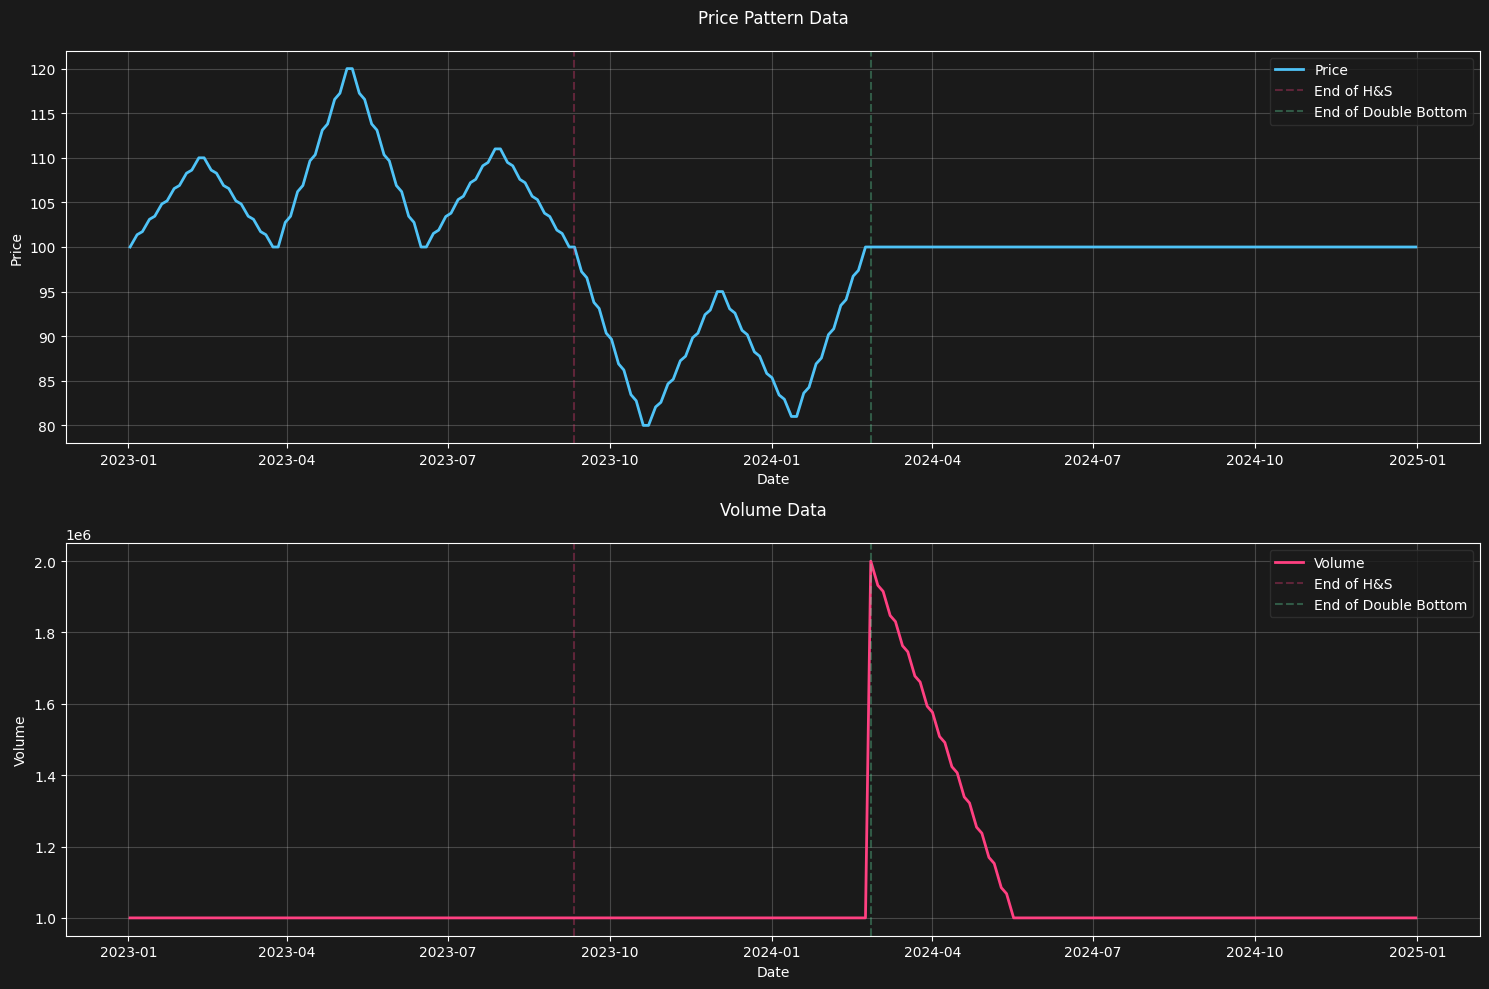

In [2]:
plot_patterns()

In [3]:
dates, prices, volume = create_test_data()

In [4]:
import pandas as pd
import numpy as np
from typing import Dict, List, Optional, Tuple
from arch import arch_model
import warnings
from scipy.signal import argrelextrema
from typing import Tuple, List, Dict, Optional
from dataclasses import dataclass
warnings.filterwarnings('ignore')

@dataclass
class TechnicalPattern:
    """
    Data class to store information about detected technical patterns in price data.
    
    Technical patterns are specific price formations that traders use to identify
    potential future price movements. Each pattern has characteristics like its
    type, location in the data, and confidence level.

    Attributes:
    -----------
    pattern_type : str
        The type of pattern detected (e.g., "HEAD_AND_SHOULDERS", "DOUBLE_BOTTOM")
    start_idx : int
        Index in the price series where the pattern begins
    end_idx : int
        Index in the price series where the pattern ends
    confidence : float
        A measure between 0 and 1 indicating how well the pattern matches ideal criteria
        Example: 0.8 means the pattern is a strong match, 0.3 suggests a weak match
    price_range : Tuple[float, float]
        The price range covered by the pattern (min_price, max_price)
        Example: If a stock forms a double bottom at $100 and peaks at $110,
                price_range would be (100.0, 110.0)

    Example:
    --------
    >>> pattern = TechnicalPattern(
    ...     pattern_type="DOUBLE_BOTTOM",
    ...     start_idx=100,
    ...     end_idx=150,
    ...     confidence=0.85,
    ...     price_range=(100.0, 110.0)
    ... )
    >>> print(f"Found {pattern.pattern_type} with {pattern.confidence:.1%} confidence")
    "Found DOUBLE_BOTTOM with 85.0% confidence"
    """
    pattern_type: str
    start_idx: int
    end_idx: int
    confidence: float
    price_range: Tuple[float, float]
    failure_reasons: Optional[Dict[str, str]] = None
    specific_points: Optional[dict] = None    

    def __post_init__(self):
        # Convert numpy integers to Python integers
        self.start_idx = int(self.start_idx)
        self.end_idx = int(self.end_idx)
        # Convert numpy numbers in price_range to Python numbers
        self.price_range = (float(self.price_range[0]), float(self.price_range[1]))
        # Convert confidence to float if needed
        self.confidence = float(self.confidence)    

@dataclass
class HeadAndShouldersPoints:
    left_shoulder_idx: int
    head_idx: int
    right_shoulder_idx: int
    left_trough_idx: int
    right_trough_idx: int
    
@dataclass
class PatternValidation:
    is_valid: bool
    confidence: float
    failure_reasons: Dict[str, str]  # Key is check name, value is failure description
    price_range: Optional[Tuple[float, float]] = None

def validate_head_and_shoulders(
    prices: np.ndarray,
    points: HeadAndShouldersPoints,
    shoulder_height_tolerance: float = 0.02,
    neckline_slope_tolerance: float = 0.02
) -> PatternValidation:
    """
    Validate whether given points form a head and shoulders pattern.
    
    Args:
        prices: Array of price values
        points: HeadAndShouldersPoints containing indices of potential pattern points
        shoulder_height_tolerance: Maximum allowed difference between shoulder heights as percentage
        neckline_slope_tolerance: Maximum allowed neckline slope as percentage
    
    Returns:
        PatternValidation object containing validation results and details
    """
    # Extract prices at pattern points
    left_shoulder = prices[points.left_shoulder_idx]
    head = prices[points.head_idx]
    right_shoulder = prices[points.right_shoulder_idx]
    left_trough = prices[points.left_trough_idx]
    right_trough = prices[points.right_trough_idx]
    
    failure_reasons = {}
    
    # Check 1: Head must be higher than both shoulders
    head_height_valid = head > left_shoulder and head > right_shoulder
    if not head_height_valid:
        failure_reasons['head_height'] = 'Head is not higher than both shoulders'
    
    # Check 2: Shoulders should be at similar heights
    shoulder_diff = abs(left_shoulder - right_shoulder) / left_shoulder
    shoulders_valid = shoulder_diff <= shoulder_height_tolerance
    if not shoulders_valid:
        failure_reasons['shoulder_heights'] = f'Shoulder height difference ({shoulder_diff:.1%}) exceeds tolerance ({shoulder_height_tolerance:.1%})'
    
    # Check 3: Neckline should be roughly horizontal
    neckline_slope = abs(right_trough - left_trough) / left_trough
    neckline_valid = neckline_slope <= neckline_slope_tolerance
    if not neckline_valid:
        failure_reasons['neckline_slope'] = f'Neckline slope ({neckline_slope:.1%}) exceeds tolerance ({neckline_slope_tolerance:.1%})'
    
    # Check 4: Pattern sequence should be valid
    sequence_valid = (points.left_shoulder_idx < points.left_trough_idx < 
                     points.head_idx < points.right_trough_idx < 
                     points.right_shoulder_idx)
    if not sequence_valid:
        failure_reasons['sequence'] = 'Points are not in correct chronological order'
    
    # Calculate confidence based on how well the pattern matches ideal conditions
    confidence_factors = {
        'head_height': 1.0 if head_height_valid else 0.0,
        'shoulder_symmetry': 1.0 - (shoulder_diff / shoulder_height_tolerance) if shoulders_valid else 0.0,
        'neckline': 1.0 - (neckline_slope / neckline_slope_tolerance) if neckline_valid else 0.0,
        'sequence': 1.0 if sequence_valid else 0.0
    }
    confidence = np.mean(list(confidence_factors.values()))
    
    is_valid = len(failure_reasons) == 0
    price_range = (min(left_trough, right_trough), head) if is_valid else None
    
    return PatternValidation(
        is_valid=is_valid,
        confidence=confidence,
        failure_reasons=failure_reasons,
        price_range=price_range
    )

class PatternRecognition:
    """
    A comprehensive framework for detecting and analyzing technical patterns in financial price data.
    
    This class implements various pattern detection algorithms to identify common technical
    trading patterns like head and shoulders, double bottoms, and volume-price divergences.
    These patterns are used by traders to make predictions about future price movements.

    Key Concepts:
    -------------
    1. Swing Points:
       - Local maxima (peaks) and minima (troughs) in price data
       - Form the building blocks of many technical patterns
       Example: In a double bottom pattern, we look for two similar price troughs

    2. Pattern Formation:
       - Specific arrangements of swing points that form recognizable patterns
       - Each pattern has criteria for price levels, timing, and symmetry
       Example: Head & shoulders pattern needs three peaks with the middle one highest

    3. Volume Confirmation:
       - Trading volume often helps confirm pattern validity
       - Volume patterns can diverge from price, signaling potential reversals
       Example: Decreasing volume during price rises might signal weakness

    Parameters:
    -----------
    prices : pd.Series
        Time series of price data (typically closing prices)
    volumes : pd.Series
        Time series of trading volume data, indexed same as prices

    Example:
    --------
    >>> # Initialize with price and volume data
    >>> pattern_finder = PatternRecognition(
    ...     prices=df['close'],
    ...     volumes=df['volume']
    ... )
    >>> 
    >>> # Find head and shoulders patterns
    >>> patterns = pattern_finder.detect_head_and_shoulders()
    >>> 
    >>> # Analyze the patterns
    >>> for pattern in patterns:
    ...     print(f"Found pattern between index {pattern.start_idx} and {pattern.end_idx}")
    ...     print(f"Price range: ${pattern.price_range[0]:.2f} to ${pattern.price_range[1]:.2f}")
    """
    def __init__(self, prices: pd.Series, volumes: pd.Series):
        self.prices = prices
        self.volumes = volumes
        self.patterns = []
    
    def find_swing_points(self) -> Tuple[np.ndarray, np.ndarray]:
        """
        Identify swing high and low points in the price series using local extrema detection.
        
        What are Swing Points?
        - Swing Highs: Local price peaks (price higher than surrounding prices)
        - Swing Lows: Local price troughs (price lower than surrounding prices)
        - Used as building blocks to identify larger technical patterns
        
        Returns:
        --------
        Tuple[np.ndarray, np.ndarray]
            Two arrays containing indices of swing highs and swing lows
            First array: Indices of swing highs
            Second array: Indices of swing lows

        Example:
        --------
        >>> highs, lows = pattern_finder.find_swing_points(window=10)
        >>> print(f"Found {len(highs)} swing highs and {len(lows)} swing lows")
        >>> 
        >>> # Get the prices at swing points
        >>> swing_high_prices = prices.iloc[highs]
        >>> swing_low_prices = prices.iloc[lows]
        """
        diff = np.diff(self.prices)
        maxima = []
        minima = []
        
        i = 0
        while i < len(diff):
            # Found increasing then decreasing (potential maximum)
            if i > 0 and diff[i-1] > 0 and diff[i] < 0:
                maxima.append(i)
                
            # Found decreasing then increasing (potential minimum)
            elif i > 0 and diff[i-1] < 0 and diff[i] > 0:
                minima.append(i)
                
            # Handle plateau
            elif diff[i] == 0:
                plateau_start = i
                # Find end of plateau
                while i < len(diff) and diff[i] == 0:
                    i += 1
                    
                plateau_end = i
                plateau_center = plateau_start + (plateau_end - plateau_start) // 2
                
                # Check if it's a maximum or minimum plateau
                if plateau_start > 0:
                    if diff[plateau_start-1] > 0 and (i < len(diff) and diff[i] < 0):
                        maxima.append(plateau_center)
                    elif diff[plateau_start-1] < 0 and (i < len(diff) and diff[i] > 0):
                        minima.append(plateau_center)
                
                continue
                
            i += 1
        
        return np.array(maxima), np.array(minima)
    
    def detect_head_and_shoulders(self) -> List[TechnicalPattern]:
        """
        Detect head and shoulders patterns in the price data.
        
        What is a Head and Shoulders Pattern?
        - A reversal pattern suggesting a trend change from up to down
        - Consists of:
          * Left Shoulder: First peak
          * Head: Higher middle peak
          * Right Shoulder: Third peak at similar height to left shoulder
          * Neckline: Support line connecting the troughs between peaks
        
        Pattern Criteria:
        1. Head must be higher than both shoulders
        2. Shoulders should be at similar price levels (within 2%)
        3. Neckline should be roughly horizontal (within 2% slope)
        
        Parameters:
        -----------
        window : int, default=20
            Window size for finding swing points
            Larger values find larger patterns
            Example: window=20 finds patterns lasting about a month

        Returns:
        --------
        List[TechnicalPattern]
            List of detected head and shoulders patterns
            Each pattern includes start/end points, confidence level, and price range

        Example:
        --------
        >>> patterns = pattern_finder.detect_head_and_shoulders()
        >>> for pattern in patterns:
        ...     print(f"Pattern found between days {pattern.start_idx} and {pattern.end_idx}")
        ...     print(f"Price range: ${pattern.price_range[0]:.2f} to ${pattern.price_range[1]:.2f}")
        ...     print(f"Confidence: {pattern.confidence:.1%}")
        """
        highs, lows = self.find_swing_points()
        patterns = []
        
        if len(highs) < 3:
            return patterns
        
        if lows[0] < highs[0]:
            lows = lows[1:]

        for i in range(len(highs) - 3):
            points = HeadAndShouldersPoints(
                left_shoulder_idx=highs[i],
                head_idx=highs[i + 1],
                right_shoulder_idx=highs[i + 2],
                left_trough_idx=lows[i],
                right_trough_idx=lows[i + 1]
            )
            
            validation = validate_head_and_shoulders(prices, points)
            if validation.is_valid:
                patterns.append((points, validation))
        
        return patterns
    
    def detect_double_bottom(self, window: int = 20, tolerance: float = 0.02) -> List[TechnicalPattern]:
        """
        Detect double bottom patterns in the price data.
        
        What is a Double Bottom Pattern?
        - A reversal pattern suggesting a trend change from down to up
        - Consists of:
          * First Bottom: Initial price trough
          * Second Bottom: Similar price trough
          * Peak: Higher price point between bottoms
        
        Pattern Criteria:
        1. Two price troughs at similar levels (within tolerance)
        2. A noticeable peak between the troughs
        3. Second bottom should confirm support level
        
        Parameters:
        -----------
        window : int, default=20
            Window size for finding swing points
            Larger values find larger patterns
            Example: window=20 finds patterns lasting about a month
        tolerance : float, default=0.02
            Maximum allowed difference between bottom prices (as percentage)
            Example: 0.02 means bottoms must be within 2% of each other

        Returns:
        --------
        List[TechnicalPattern]
            List of detected double bottom patterns
            Each pattern includes start/end points, confidence level, and price range

        Example:
        --------
        >>> patterns = pattern_finder.detect_double_bottom(tolerance=0.03)
        >>> if patterns:
        ...     pattern = patterns[0]
        ...     print(f"Double bottom found with bottoms at ${pattern.price_range[0]:.2f}")
        ...     print(f"Pattern confidence: {pattern.confidence:.1%}")
        """
        patterns = []
        _, lows = self.find_swing_points(window)
        
        for i in range(len(lows) - 1):
            bottom1 = self.prices.iloc[lows[i]]
            bottom2 = self.prices.iloc[lows[i + 1]]
            
            if abs(bottom1 - bottom2) / bottom1 < tolerance:
                middle_idx = slice(lows[i], lows[i + 1])
                middle_high = self.prices.iloc[middle_idx].max()
                
                pattern = TechnicalPattern(
                    pattern_type="DOUBLE_BOTTOM",
                    start_idx=lows[i],
                    end_idx=lows[i + 1],
                    confidence=0.7,
                    price_range=(min(bottom1, bottom2), middle_high)
                )
                patterns.append(pattern)
        
        return patterns
    
    def detect_volume_price_divergence(self, window: int = 20) -> List[TechnicalPattern]:
        """
        Detect divergences between price and volume trends.
        
        What is Volume-Price Divergence?
        - Occurs when price and volume trends move in opposite directions
        - Often signals potential trend reversals
        - Examples:
          * Prices rising but volume declining (weak uptrend)
          * Prices falling but volume declining (weak downtrend)
        
        Why Important?
        - Volume often confirms price movements
        - Divergences suggest current trend might be weakening
        - Used to identify potential trend reversals
        
        Parameters:
        -----------
        window : int, default=20
            Window size for calculating trends
            Larger windows smooth out noise but lag more
            Example: window=20 looks at monthly trends

        Returns:
        --------
        List[TechnicalPattern]
            List of detected divergence patterns
            Each pattern includes:
            - Start/end points of divergence
            - Confidence (based on degree of divergence)
            - Price range during divergence

        Example:
        --------
        >>> patterns = pattern_finder.detect_volume_price_divergence()
        >>> for pattern in patterns:
        ...     print(f"Divergence found from index {pattern.start_idx} to {pattern.end_idx}")
        ...     print(f"Confidence in signal: {pattern.confidence:.1%}")
        """
        patterns = []
        
        price_trend = self.prices.rolling(window).mean().pct_change()
        volume_trend = self.volumes.rolling(window).mean().pct_change()
        
        for i in range(window, len(self.prices) - window):
            price_direction = np.sign(price_trend.iloc[i])
            volume_direction = np.sign(volume_trend.iloc[i])
            
            if price_direction != volume_direction:
                pattern = TechnicalPattern(
                    pattern_type="VOLUME_PRICE_DIVERGENCE",
                    start_idx=i - window,
                    end_idx=i,
                    confidence=abs(price_trend.iloc[i] - volume_trend.iloc[i]),
                    price_range=(self.prices.iloc[i-window], self.prices.iloc[i])
                )
                patterns.append(pattern)
        
        return patterns

In [30]:
pattern_detector = PatternRecognition(pd.Series(prices, index=dates), pd.Series(volume, index=dates))
highs, lows = pattern_detector.find_swing_points()

In [31]:
highs

array([ 29,  89, 149, 239])

In [32]:
lows

array([ 59, 119, 209, 269])

In [33]:
pattern_detector.detect_head_and_shoulders()

[(HeadAndShouldersPoints(left_shoulder_idx=np.int64(29), head_idx=np.int64(89), right_shoulder_idx=np.int64(149), left_trough_idx=np.int64(59), right_trough_idx=np.int64(119)),
  PatternValidation(is_valid=True, confidence=np.float64(0.8863636363636364), failure_reasons={}, price_range=(np.float64(100.0), np.float64(120.0))))]

In [34]:
# For testing specific points
points = HeadAndShouldersPoints(
    left_shoulder_idx=29,
    head_idx=89,
    right_shoulder_idx=149,
    left_trough_idx=59,
    right_trough_idx=119
)

In [35]:
validate_head_and_shoulders(prices, points)

PatternValidation(is_valid=True, confidence=np.float64(0.8863636363636364), failure_reasons={}, price_range=(np.float64(100.0), np.float64(120.0)))

In [55]:
data = {
    'TEST': pd.DataFrame({
        'open': prices,
        'high': prices * 1.01,
        'low': prices * 0.99,
        'close': prices,
        'volume': volume
    }, index = dates)
}

In [37]:
from market_analyzer import MarketAnalyzer
market_analyzer_with_patterns = MarketAnalyzer(data=data, market_indices=[])

In [38]:
patterns = market_analyzer_with_patterns.analyze_patterns('TEST')

In [39]:
patterns.keys()

dict_keys(['head_and_shoulders', 'double_bottom', 'volume_price_divergence'])

In [40]:
#[patterns[key] for key in patterns.keys()]
#patterns["head_and_shoulders"][0]
def list_of_lists_to_flat_list(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]
#list_of_lists_to_flat_list([patterns[key] for key in patterns])

#[pd.Series([isinstance(pattern, TechnicalPattern), 0 <= pattern.confidence <= 1, pattern.start_idx < pattern.end_idx, pattern.price_range[0] < pattern.price_range[1]], name=pattern.pattern_type) for pattern in list_of_lists_to_flat_list([patterns[key] for key in patterns])]
#pd.DataFrame([pd.Series([isinstance(pattern, TechnicalPattern), 0 <= pattern.confidence <= 1, pattern.start_idx < pattern.end_idx, pattern.price_range[0] < pattern.price_range[1]], name=pattern.pattern_type) for pattern in list_of_lists_to_flat_list([patterns[key] for key in patterns])])
#columns=["is_technical_pattern", "pattern_confidence_btwn_0_1", "start_index<end_index","high_price>low_price"]
pattern_validation = pd.DataFrame([pd.Series([pattern, pattern.confidence, pattern.start_idx, pattern.end_idx, pattern.price_range[0], pattern.price_range[1]], name=pattern.pattern_type) for pattern in list_of_lists_to_flat_list([patterns[key] for key in patterns])])
pattern_validation.columns = ["return_type", "confidence", "start_index", "end_index", "low_price", "high_price"]
pattern_validation.index.name = "pattern_type"
pattern_validation = pattern_validation.reset_index()
pattern_validation

,pattern_type,return_type,confidence,start_index,end_index,low_price,high_price
0,HEAD_AND_SHOULDERS,TechnicalPattern(pattern_type='HEAD_AND_SHOULD...,0.8,29,149,59.000000,89.000000
1,DOUBLE_BOTTOM,"TechnicalPattern(pattern_type='DOUBLE_BOTTOM',...",0.7,59,119,100.000000,120.000000
2,DOUBLE_BOTTOM,"TechnicalPattern(pattern_type='DOUBLE_BOTTOM',...",0.7,209,269,80.000000,95.000000
3,VOLUME_PRICE_DIVERGENCE,TechnicalPattern(pattern_type='VOLUME_PRICE_DI...,0.0,0,20,100.000000,106.896552
4,VOLUME_PRICE_DIVERGENCE,TechnicalPattern(pattern_type='VOLUME_PRICE_DI...,0.0,1,21,100.344828,107.241379
...,...,...,...,...,...,...,...
245,VOLUME_PRICE_DIVERGENCE,TechnicalPattern(pattern_type='VOLUME_PRICE_DI...,0.0,275,295,84.275862,97.379310
246,VOLUME_PRICE_DIVERGENCE,TechnicalPattern(pattern_type='VOLUME_PRICE_DI...,0.0,276,296,84.931034,98.034483
247,VOLUME_PRICE_DIVERGENCE,TechnicalPattern(pattern_type='VOLUME_PRICE_DI...,0.0,277,297,85.586207,98.689655
248,VOLUME_PRICE_DIVERGENCE,TechnicalPattern(pattern_type='VOLUME_PRICE_DI...,0.0,278,298,86.241379,99.344828


In [41]:
pattern_validation["pattern_type"].value_counts()

pattern_type
VOLUME_PRICE_DIVERGENCE    247
DOUBLE_BOTTOM                2
HEAD_AND_SHOULDERS           1
Name: count, dtype: int64

In [42]:
#pattern_validation["return_type"].apply(lambda x: isinstance(x, TechnicalPattern))
pattern_validation["return_type"].iloc[0]

TechnicalPattern(pattern_type='HEAD_AND_SHOULDERS', start_idx=29, end_idx=149, confidence=0.8, price_range=(59.0, 89.0), failure_reasons=None, specific_points=None)

In [43]:
isinstance(pattern_validation["return_type"].iloc[0], TechnicalPattern)

True

In [44]:
def convert_pattern(pattern):
    return TechnicalPattern(
        pattern_type=pattern.pattern_type,
        start_idx=int(pattern.start_idx),
        end_idx=int(pattern.end_idx),
        confidence=float(pattern.confidence),
        price_range=(float(pattern.price_range[0]), float(pattern.price_range[1])),
        failure_reasons=pattern.failure_reasons,
        specific_points=pattern.specific_points
    )

convert_pattern(pattern_validation["return_type"].iloc[0])

TechnicalPattern(pattern_type='HEAD_AND_SHOULDERS', start_idx=29, end_idx=149, confidence=0.8, price_range=(59.0, 89.0), failure_reasons=None, specific_points=None)

In [45]:
from market_analyzer import TechnicalPattern
isinstance(convert_pattern(pattern_validation["return_type"].iloc[0]), TechnicalPattern)

True

In [46]:
# Print what we're actually dealing with
pattern = pattern_validation["return_type"].iloc[0]
print(f"Type: {type(pattern)}")
print(f"Pattern dir: {dir(pattern)}")

Type: <class 'market_analyzer.TechnicalPattern'>
Pattern dir: ['__annotations__', '__class__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__match_args__', '__module__', '__ne__', '__new__', '__post_init__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'confidence', 'end_idx', 'failure_reasons', 'pattern_type', 'price_range', 'specific_points', 'start_idx']


In [47]:
pattern_validation["return_type"].apply(lambda x: isinstance(x, TechnicalPattern)).value_counts()

return_type
True    250
Name: count, dtype: int64

In [48]:
pattern_validation["confidence"].describe()

count    250.000000
mean       0.008800
std        0.080177
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.800000
Name: confidence, dtype: float64

In [49]:
(pattern_validation["start_index"] < pattern_validation["end_index"]).value_counts()

True    250
Name: count, dtype: int64

In [50]:
(pattern_validation["high_price"] > pattern_validation["low_price"]).value_counts()

True    250
Name: count, dtype: int64

In [51]:
pattern_validation

,pattern_type,return_type,confidence,start_index,end_index,low_price,high_price
0,HEAD_AND_SHOULDERS,TechnicalPattern(pattern_type='HEAD_AND_SHOULD...,0.8,29,149,59.000000,89.000000
1,DOUBLE_BOTTOM,"TechnicalPattern(pattern_type='DOUBLE_BOTTOM',...",0.7,59,119,100.000000,120.000000
2,DOUBLE_BOTTOM,"TechnicalPattern(pattern_type='DOUBLE_BOTTOM',...",0.7,209,269,80.000000,95.000000
3,VOLUME_PRICE_DIVERGENCE,TechnicalPattern(pattern_type='VOLUME_PRICE_DI...,0.0,0,20,100.000000,106.896552
4,VOLUME_PRICE_DIVERGENCE,TechnicalPattern(pattern_type='VOLUME_PRICE_DI...,0.0,1,21,100.344828,107.241379
...,...,...,...,...,...,...,...
245,VOLUME_PRICE_DIVERGENCE,TechnicalPattern(pattern_type='VOLUME_PRICE_DI...,0.0,275,295,84.275862,97.379310
246,VOLUME_PRICE_DIVERGENCE,TechnicalPattern(pattern_type='VOLUME_PRICE_DI...,0.0,276,296,84.931034,98.034483
247,VOLUME_PRICE_DIVERGENCE,TechnicalPattern(pattern_type='VOLUME_PRICE_DI...,0.0,277,297,85.586207,98.689655
248,VOLUME_PRICE_DIVERGENCE,TechnicalPattern(pattern_type='VOLUME_PRICE_DI...,0.0,278,298,86.241379,99.344828


In [56]:
data["TEST"]

,open,high,low,close,volume
2023-01-02,100.000000,101.000000,99.000000,100.000000,1000000.0
2023-01-03,100.344828,101.348276,99.341379,100.344828,1000000.0
2023-01-04,100.689655,101.696552,99.682759,100.689655,1000000.0
2023-01-05,101.034483,102.044828,100.024138,101.034483,1000000.0
2023-01-06,101.379310,102.393103,100.365517,101.379310,1000000.0
...,...,...,...,...,...
2024-12-25,100.000000,101.000000,99.000000,100.000000,1000000.0
2024-12-26,100.000000,101.000000,99.000000,100.000000,1000000.0
2024-12-27,100.000000,101.000000,99.000000,100.000000,1000000.0
2024-12-30,100.000000,101.000000,99.000000,100.000000,1000000.0


In [79]:
def pattern_dates(pattern_row, data):
    return pd.DataFrame([[data.index[pattern_row["start_index"]], data.index[pattern_row["end_index"]]]], columns=["start_date", "end_date"], index = [pattern_row.name])

In [80]:
pattern_dates(pattern_validation.iloc[0], data["TEST"])

,start_date,end_date
0,2023-02-10,2023-07-28


In [86]:
pattern_validation = pattern_validation.join(pd.concat([el for el in pattern_validation.apply(lambda pattern_row: pattern_dates(pattern_row, data["TEST"]), axis=1)]))

In [87]:
pattern_validation

,pattern_type,return_type,confidence,start_index,end_index,low_price,high_price,start_date,end_date
0,HEAD_AND_SHOULDERS,TechnicalPattern(pattern_type='HEAD_AND_SHOULD...,0.8,29,149,59.000000,89.000000,2023-02-10,2023-07-28
1,DOUBLE_BOTTOM,"TechnicalPattern(pattern_type='DOUBLE_BOTTOM',...",0.7,59,119,100.000000,120.000000,2023-03-24,2023-06-16
2,DOUBLE_BOTTOM,"TechnicalPattern(pattern_type='DOUBLE_BOTTOM',...",0.7,209,269,80.000000,95.000000,2023-10-20,2024-01-12
3,VOLUME_PRICE_DIVERGENCE,TechnicalPattern(pattern_type='VOLUME_PRICE_DI...,0.0,0,20,100.000000,106.896552,2023-01-02,2023-01-30
4,VOLUME_PRICE_DIVERGENCE,TechnicalPattern(pattern_type='VOLUME_PRICE_DI...,0.0,1,21,100.344828,107.241379,2023-01-03,2023-01-31
...,...,...,...,...,...,...,...,...,...
245,VOLUME_PRICE_DIVERGENCE,TechnicalPattern(pattern_type='VOLUME_PRICE_DI...,0.0,275,295,84.275862,97.379310,2024-01-22,2024-02-19
246,VOLUME_PRICE_DIVERGENCE,TechnicalPattern(pattern_type='VOLUME_PRICE_DI...,0.0,276,296,84.931034,98.034483,2024-01-23,2024-02-20
247,VOLUME_PRICE_DIVERGENCE,TechnicalPattern(pattern_type='VOLUME_PRICE_DI...,0.0,277,297,85.586207,98.689655,2024-01-24,2024-02-21
248,VOLUME_PRICE_DIVERGENCE,TechnicalPattern(pattern_type='VOLUME_PRICE_DI...,0.0,278,298,86.241379,99.344828,2024-01-25,2024-02-22


In [89]:
(pattern_validation["end_date"] > pattern_validation["start_date"]).value_counts()

True    250
Name: count, dtype: int64

In [1]:
import numpy as np
import pandas as pd
np.random.seed(42)
# Create returns with known mean and volatility
returns = pd.Series(
    np.random.normal(loc=0.03, scale=0.02, size=252),
    index=pd.date_range('2023-01-01', periods=252, freq='B')
)
windows = [5, 21, 63]
quantiles = [0.1, 0.5, 0.9]
window = windows[0]
returns.rolling(window).apply(lambda x: pd.Series(np.percentile(x, [q * 100 for q in quantiles]), index = quantiles))

TypeError: cannot convert the series to <class 'float'>

In [6]:
#returns.rolling(window)
returns.rolling(window).apply(lambda x: list(np.percentile(x, [q * 100 for q in quantiles])))

TypeError: must be real number, not list